In [13]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from unet import UNet  
from utils import preprocess_image, postprocess_mask

In [14]:
def visualize_results(image, pred_mask):
    plt.figure(figsize=(8,4))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()
    plt.close()

In [15]:
def run_inference(model, image_folder, save_results=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Get image files
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Define output folders
    output_mask_dir = "output/results"
    output_visualized_dir = "output/visualized"
    
    os.makedirs(output_mask_dir, exist_ok=True)
    os.makedirs(output_visualized_dir, exist_ok=True)

    for image_name in image_files:
        image_path = os.path.join(image_folder, image_name)
        image = preprocess_image(image_path).to(device)

        with torch.no_grad():
            pred_mask = model(image)
            pred_mask = torch.sigmoid(pred_mask)
        
        pred_mask = postprocess_mask(pred_mask)  # Ensure correct format

        # Load the original image for visualization
        original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Save results
        if save_results:
            # Save the predicted mask
            mask_save_path = os.path.join(output_mask_dir, f"mask_{image_name}")
            cv2.imwrite(mask_save_path, (pred_mask * 255).astype(np.uint8))  # Normalize to [0,255]

            # Save visualized output
            vis_save_path = os.path.join(output_visualized_dir, f"visualized_{image_name}")
            plt.imsave(vis_save_path, pred_mask, cmap="gray")
        
        # Display results inline
        visualize_results(original_image, pred_mask)


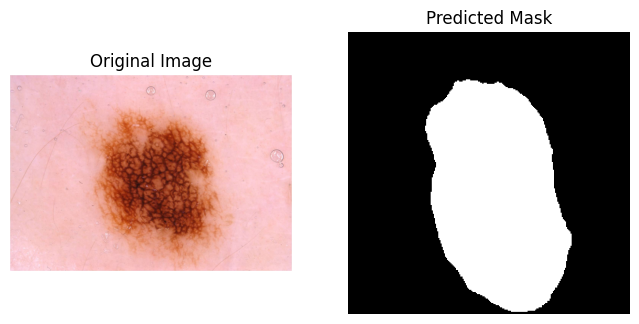

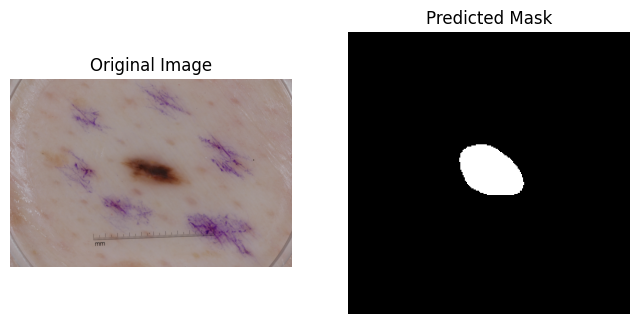

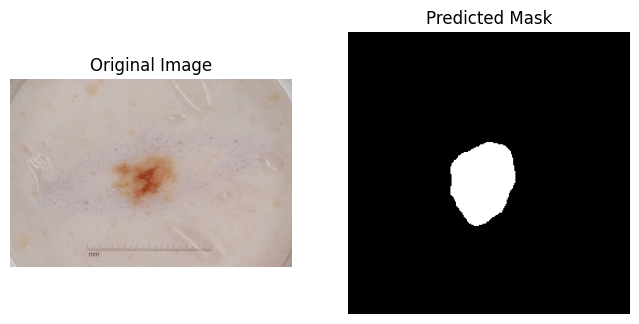

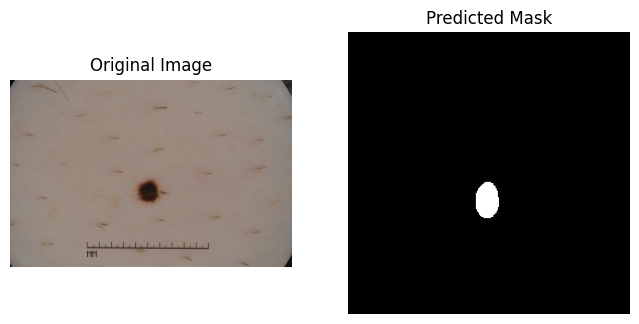

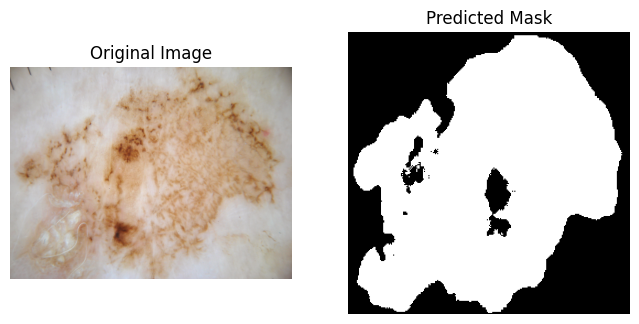

In [16]:
model_path = "/teamspace/studios/this_studio/output/model_path/unet.pth"  # Update this path
image_folder = "/teamspace/studios/this_studio/data/isic_dataset/test"  # Update this path

model = UNet(in_channels=3, out_channels=1)  # Assuming 3-channel RGB input
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Run inference
run_inference(model, image_folder, save_results=True)